### Practice 4 - Evaluating porfolio risk and return

Markos Flavio B. G. O.

__Context: Modern portfolio theory.__

__Course: Portfolio Selection and Risk Management (Coursera, Rice University)__

The objective of this notebook is to implement the basic risk and return evaluations of a portfolio. It also plots the mean-variance frontier (with and without including short-selling) from a set of  portfolios.

It's based on the code at https://github.com/roesenerm/MPT and FinQuest Youtube channel (https://www.youtube.com/channel/UCNe-4gYVUAHD6As0Hq3DvaQ).
    
__Specific objectives__

    1. Getting data from QUANDL
    2. Computing covariance and correlation
    3. Computing covariance and correlation matrices
    4. Computing expected portfolio return
    5. Computing expected portfolio risk
    5. How does correlation affects portfolio's variance?
    6. The relashionship between correlation and portfolio variance
    7. Building the mean-variance frontier

In [1]:
import quandl
quandl.ApiConfig.api_key = "_x2A1JTgkKbWjn2NcgJ8" # api key for markos.flavio@hotmail.com
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import itertools

#### 1. Getting data from QUANDL

For free users, the API limits how many days can be retrieved.

In [2]:
prices = quandl.get_table('SHARADAR/SEP', ticker=['TSLA', 'XOM'], date={'lte':'2018-12-31'}, paginate=True)
prices.head()

,ticker,date,open,high,low,close,volume,dividends,closeunadj,lastupdated
None,,,,,,,,,,
0,XOM,2018-12-31,68.32,69.145,67.66,68.19,15807007.0,0.0,68.19,2020-05-01
1,XOM,2018-12-28,69.18,69.580,67.82,68.17,19706697.0,0.0,68.17,2020-05-01
2,XOM,2018-12-27,67.74,68.940,66.08,68.94,22077044.0,0.0,68.94,2020-05-01
3,XOM,2018-12-26,66.18,68.655,64.65,68.64,24887738.0,0.0,68.64,2020-05-01
4,XOM,2018-12-24,66.87,67.530,65.44,65.51,14262825.0,0.0,65.51,2020-05-01


#### 2. Computing covariance and correlation

In [3]:
pivoted = prices.pivot(index='date', columns='ticker', values='close') # reshaping data based on column values
pivoted.tail()

ticker,TSLA,XOM
date,,
2018-12-24,295.39,65.51
2018-12-26,326.09,68.64
2018-12-27,316.13,68.94
2018-12-28,333.87,68.17
2018-12-31,332.80,68.19


In [4]:
df = pivoted.pct_change() # getting daily gross return
df.head()

ticker,TSLA,XOM
date,,
2018-09-04,NaN,NaN
2018-09-05,-0.028413,0.013327
2018-09-06,0.000748,-0.011062
2018-09-07,-0.063036,0.017027
2018-09-10,0.084562,-0.001466


#### Variance Formula
$$s^2 = \frac{\sum_{i=1}^N (x_i - \bar{x})^2}{N-1}$$

#### Standard Deviation Formula
$$s = \sqrt{\frac{\sum_{i=1}^N (x_i - \bar{x})^2}{N-1} }$$

#### Covariance Formula
$$COV_{ij} = \frac{\sum_{i=1j=1}^N (x_i - \bar{x_i})(x_j - \bar{x_j})}{N-1}$$

#### Correlation Formula
$$p(R_i,R_j) = \frac{COV(R_i, R_j)}{\sigma_i \sigma_j}$$

In [5]:
# evaluating the daily variance
var_tsla = df['TSLA'].var()
var_xom = df['XOM'].var()
print('Var. TSLA', var_tsla)
print('Var. XOM', var_xom)

Var. TSLA 0.0019831648958397994
Var. XOM 0.00022571746193817468


In [6]:
# evaluating the daily std
std_tsla = df['TSLA'].std()
std_xom = df['XOM'].std()
print('Std. TSLA', std_tsla)
print('Std. XOM', std_xom)

Std. TSLA 0.044532739595041754
Std. XOM 0.015023896363399698


Assets prices are often **assumed** to follow a lognormal distribution. This modeling (among another things) deals with the property that prices cannot be negative. $ln(1+r)$ is also equal to the continuously componded rate of return that will result in the return at the next period. Thus, it's a continuous compounded rate and cannot be added to build a portfolio return (simple returns should be used instead).

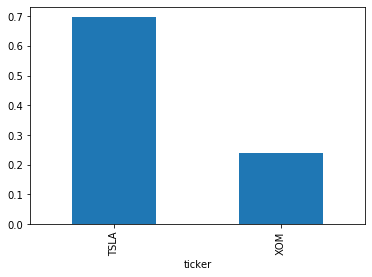

In [7]:
# plotting the annualized std deviation of the log returns
pivoted.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(252)).plot(kind='bar')

In [8]:
# evaluating the covariance
print('Covar. TSLA/XOM', df['TSLA'].cov(df['XOM'])/(std_tsla*std_xom))
print('Covar. XOM/TSLA', df['XOM'].cov(df['TSLA'])/(std_tsla*std_xom)) # same value

Covar. TSLA/XOM 0.320913184033963
Covar. XOM/TSLA 0.320913184033963


In [9]:
# evaluating the correlation
print('Corr. TSLA/XOM', df['TSLA'].corr(df['XOM']))
print('Corr. XOM/TSLA', df['XOM'].corr(df['TSLA'])) # same value

Corr. TSLA/XOM 0.320913184033963
Corr. XOM/TSLA 0.320913184033963


#### 3. Computing covariance and correlation matrices

For this exercise, we expand our data set to include 30 tickers.

In [10]:
prices = quandl.get_table('SHARADAR/SEP', date={'lte':'2018-12-31'}, paginate=True) # two years data
print(prices.head())
print(prices['ticker'].unique())
print(len(prices['ticker'].unique()))

     ticker       date   open    high    low  close      volume  dividends  \
None                                                                         
0       XOM 2018-12-31  68.32  69.145  67.66  68.19  15807007.0        0.0   
1       XOM 2018-12-28  69.18  69.580  67.82  68.17  19706697.0        0.0   
2       XOM 2018-12-27  67.74  68.940  66.08  68.94  22077044.0        0.0   
3       XOM 2018-12-26  66.18  68.655  64.65  68.64  24887738.0        0.0   
4       XOM 2018-12-24  66.87  67.530  65.44  65.51  14262825.0        0.0   

      closeunadj lastupdated  
None                          
0          68.19  2020-05-01  
1          68.17  2020-05-01  
2          68.94  2020-05-01  
3          68.64  2020-05-01  
4          65.51  2020-05-01  
['XOM' 'WMT' 'VZ' 'V' 'UNH' 'TSLA' 'TRV' 'PG' 'PFE' 'NKE' 'MSFT' 'MRK'
 'MMM' 'MCD' 'KO' 'JPM' 'JNJ' 'INTC' 'IBM' 'HD' 'GS' 'GE' 'DIS' 'DD' 'CVX'
 'CSCO' 'CAT' 'BA' 'AXP' 'AAPL']
30


Computing the log returns (not annualized).

In [12]:
df = prices.pivot(index='date', columns='ticker', values='close').pct_change().apply(lambda x: np.log(1+x))
df.head()

ticker,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GE,GS,...,NKE,PFE,PG,TRV,TSLA,UNH,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2018-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05,-0.006546,-0.012507,0.001241,0.016857,-0.009684,0.000421,0.004722,-0.008880,-0.008720,-0.000421,...,0.004012,0.011536,0.007109,0.003475,-0.028825,-0.003245,-0.035326,0.011775,0.013127,0.013239
2018-09-06,-0.016757,-0.002653,0.013153,0.006946,0.000212,-0.031521,0.000428,0.003543,-0.003989,-0.012879,...,0.005988,-0.001674,-0.007714,-0.000151,0.000748,0.007482,0.012745,0.008695,-0.001761,-0.011124
2018-09-07,-0.008101,0.006431,-0.005681,-0.001767,-0.004877,-0.005482,-0.001142,0.006419,-0.008832,-0.002604,...,-0.001245,0.010002,-0.008994,-0.018884,-0.065111,-0.005094,-0.009037,-0.005356,-0.006449,0.016884
2018-09-10,-0.013512,0.011342,-0.021473,0.005152,0.000425,-0.001048,0.000857,-0.002617,0.008832,-0.008587,...,0.022168,-0.003323,0.005722,-0.019326,0.081176,-0.032389,0.006126,0.002220,0.011104,-0.001468


In [13]:
# computing the covariance matrix
df.cov()

ticker,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GE,GS,...,NKE,PFE,PG,TRV,TSLA,UNH,V,VZ,WMT,XOM
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000553,0.000254,0.000357,0.000330,0.000338,0.000191,0.000259,0.000241,0.000268,0.000298,...,0.000266,0.000193,0.000068,0.000170,0.000350,0.000269,0.000380,0.000022,0.000154,0.000193
AXP,0.000254,0.000279,0.000208,0.000248,0.000238,0.000169,0.000209,0.000174,0.000157,0.000237,...,0.000178,0.000143,0.000131,0.000142,0.000281,0.000188,0.000269,0.000062,0.000127,0.000151
BA,0.000357,0.000208,0.000508,0.000354,0.000275,0.000219,0.000249,0.000169,0.000192,0.000244,...,0.000292,0.000143,0.000084,0.000155,0.000222,0.000238,0.000324,0.000016,0.000173,0.000181
CAT,0.000330,0.000248,0.000354,0.000618,0.000327,0.000256,0.000371,0.000209,0.000146,0.000308,...,0.000334,0.000193,0.000054,0.000184,0.000184,0.000240,0.000355,-0.000005,0.000135,0.000233
CSCO,0.000338,0.000238,0.000275,0.000327,0.000383,0.000208,0.000234,0.000196,0.000154,0.000260,...,0.000269,0.000195,0.000096,0.000160,0.000309,0.000239,0.000343,0.000066,0.000138,0.000188
CVX,0.000191,0.000169,0.000219,0.000256,0.000208,0.000290,0.000155,0.000155,0.000123,0.000179,...,0.000200,0.000139,0.000079,0.000142,0.000222,0.000172,0.000188,0.000049,0.000123,0.000216
DD,0.000259,0.000209,0.000249,0.000371,0.000234,0.000155,0.000385,0.000160,0.000101,0.000237,...,0.000263,0.000147,0.000066,0.000140,0.000255,0.000185,0.000271,0.000019,0.000117,0.000166
DIS,0.000241,0.000174,0.000169,0.000209,0.000196,0.000155,0.000160,0.000244,0.000156,0.000188,...,0.000161,0.000147,0.000093,0.000117,0.000196,0.000174,0.000214,0.000052,0.000126,0.000147
GE,0.000268,0.000157,0.000192,0.000146,0.000154,0.000123,0.000101,0.000156,0.001067,0.000230,...,0.000070,0.000097,0.000065,0.000120,0.000356,0.000163,0.000182,0.000021,0.000109,0.000107


In [14]:
# computing the correlation matrix
df.corr()

ticker,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GE,GS,...,NKE,PFE,PG,TRV,TSLA,UNH,V,VZ,WMT,XOM
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,1.000000,0.645995,0.673536,0.564669,0.734035,0.477427,0.560807,0.656209,0.349174,0.642296,...,0.515308,0.566891,0.185961,0.518922,0.339118,0.680690,0.769801,0.071528,0.483116,0.545198
AXP,0.645995,1.000000,0.551432,0.597585,0.727301,0.594679,0.638189,0.668141,0.288262,0.717048,...,0.485469,0.591275,0.505663,0.610617,0.383275,0.669714,0.768425,0.277343,0.560661,0.598855
BA,0.673536,0.551432,1.000000,0.632049,0.623420,0.571308,0.564364,0.481870,0.261337,0.549282,...,0.591256,0.439183,0.241142,0.493570,0.223962,0.629390,0.685727,0.054878,0.565699,0.534062
CAT,0.564669,0.597585,0.632049,1.000000,0.671673,0.604852,0.760665,0.539799,0.180346,0.627769,...,0.612187,0.537021,0.140192,0.529514,0.168254,0.574218,0.680412,-0.015947,0.402268,0.621743
CSCO,0.734035,0.727301,0.623420,0.671673,1.000000,0.623564,0.608477,0.640439,0.240179,0.671347,...,0.626173,0.688074,0.315397,0.585791,0.358886,0.727611,0.834053,0.253643,0.521875,0.637274
CVX,0.477427,0.594679,0.571308,0.604852,0.623564,1.000000,0.462853,0.581180,0.220680,0.531483,...,0.533963,0.563839,0.298183,0.598103,0.296095,0.600513,0.526219,0.213992,0.535055,0.842528
DD,0.560807,0.638189,0.564364,0.760665,0.608477,0.462853,1.000000,0.521181,0.157147,0.612758,...,0.610002,0.519275,0.216921,0.512623,0.295895,0.563082,0.657689,0.071974,0.439729,0.562916
DIS,0.656209,0.668141,0.481870,0.539799,0.640439,0.581180,0.521181,1.000000,0.305501,0.610243,...,0.469412,0.649298,0.383127,0.537932,0.285403,0.662324,0.652938,0.249743,0.596742,0.624260
GE,0.349174,0.288262,0.261337,0.180346,0.240179,0.220680,0.157147,0.305501,1.000000,0.357043,...,0.097926,0.205183,0.128409,0.262394,0.248281,0.296604,0.264960,0.048929,0.246348,0.217780


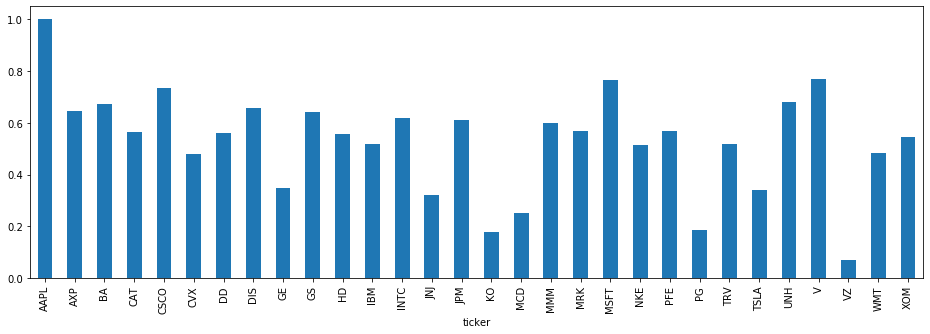

In [15]:
# plotting the correlations of the 'AAPL' ticker
plt.figure(figsize=(16,5))
df.corr()['AAPL'].plot(kind='bar')

#### 4. Computing expected portfolio return

#### Portfolio Expected Return Formula
$$E(R_p) = w_1E(R_1) + w_2E(R_2) + ... + w_nE(R_n)$$

In [16]:
prices = quandl.get_table('SHARADAR/SEP', ticker=['AAPL', 'NKE'], date={'lte':'2018-12-31'}, paginate=True)
df = prices.pivot(index='date', columns='ticker', values='close').pct_change()
df.head()

ticker,AAPL,NKE
date,,
2018-09-04,NaN,NaN
2018-09-05,-0.006525,0.004020
2018-09-06,-0.016617,0.006006
2018-09-07,-0.008068,-0.001244
2018-09-10,-0.013421,0.022416


To calculate the expected daily return of a portfolio, we **must** use simple (discrete) returns instead of log returns.

In [17]:
df.mean()

ticker
AAPL   -0.004285
NKE    -0.000639
dtype: float64

In [18]:
def portfolio_return(df, w):
    '''
    Calculates the expected return of a portfolio.
    
    Parameters:
        df (DataFrame): a DataFrame where the index has type 'datetime64' and columns are percentage changes in price.
        w (list): a list of weights that composes the portfolio distribution. The weights must sum up to one.
    Returns:
        port_e_r (float): the portfolio expected return.
    '''
    e_r = df.mean()
    print('Expected return for each company', e_r)
    port_e_r = np.dot(w, e_r)
    return port_e_r

In [19]:
p_er = portfolio_return(df, [.75, .25]) # daily expected reward

Expected return for each company ticker
AAPL   -0.004285
NKE    -0.000639
dtype: float64


Interestingly, for the given period, both assets delivered negative returns.

#### 5. Computing expected portfolio risk

#### Portofilio Variance Formula
$$\sigma^2(R_p) = w_1w_1\sigma^2(R_1) + w_1w_2COV(R_1,R_2) + w_2w_2\sigma^2(R_2) + w_2w_1COV(R_1,R_2)$$

Simplifying a little bit:
$$\sigma^2(R_p) = w_1w_1\sigma^2(R_1) + w_2w_2\sigma^2(R_2) + 2w_1w_2COV(R_1,R_2)$$

#### Correlation & Covariance Formulas
$$p(R_i,R_j) = \frac{COV(R_i, R_j)}{\sigma_i \sigma_j}$$
$$COV(R_i,R_j) = p(R_i,R_j)\sigma_i\sigma_j$$

#### Portofilio Variance Formula (in terms of correlation)
$$\sigma^2(R_p) = w_1^2\sigma^2(R_1) + w_2^2\sigma^2(R_2) + 2w_1w_2p(R_i,R_j)\sigma_i \sigma_j$$

#### Portfolio Standard Deviation Formula
$$\sigma(R_p) = \sqrt{\sigma^2(R_p)}$$

Using the same data of the previous experiment:

In [20]:
df.head()

ticker,AAPL,NKE
date,,
2018-09-04,NaN,NaN
2018-09-05,-0.006525,0.004020
2018-09-06,-0.016617,0.006006
2018-09-07,-0.008068,-0.001244
2018-09-10,-0.013421,0.022416


*Is it useful to use log returns when evaluating portfolio risk?*

In [21]:
# Getting the log returns.
#df = df.apply(lambda x: np.log(1+x))
#df[:2]

Computing the covariance matrix.

In [22]:
cov_matrix = df.cov()
cov_matrix

ticker,AAPL,NKE
ticker,,
AAPL,0.000548,0.000266
NKE,0.000266,0.000484


Computing the portfolio variance ($risk^2$) with given weights:
1. Using Pandas.
2. Using Numpy.

In [23]:
# Pandas
w = {'AAPL':.75, 'NKE':.25} 
cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()

0.00043829052709490714

In [24]:
# Numpy
cov_matrix_arr = np.array(cov_matrix)
w_arr = np.array(list(w.values())).reshape(1,-1) # nd-array
(w_arr.dot(cov_matrix_arr)).dot(w_arr.T)[0][0]

0.00043829052709490714

Testing the speedness of each method.

In [25]:
if False: # prevents running
    T = 10000
    start_time = time.time()
    for t in range(T):
        cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()
    print('Pandas elapsed time for {0} evaluations: {1} sec.'.format(time.time()-start_time, str(T)))
    start_time = time.time()
    for t in range(T):
        (w_arr.dot(cov_matrix_arr)).dot(w_arr.T)[0][0]
    print('Numpy elapsed time for {0} evaluations: {1} sec.'.format(time.time()-start_time, str(T)))

Using Numpy lib is much more efficient.

In [26]:
def portfolio_std(df, w):
    '''
    Calculates the expected risk of a portfolio.
    
    Parameters:
        df (DataFrame): a DataFrame where the index has type 'datetime64' and columns are gross returns.
        w (list): a list of weights that composes the portfolio distribution. The weights must sum up to one.
    Returns:
        port_e_std (float): the portfolio expected standard deviation.
    '''
    cov_matrix = np.array(df.cov())
    w = np.array(w).reshape(1,-1)
    port_e_std = np.sqrt((w.dot(cov_matrix)).dot(w.T)[0][0])
    
    return port_e_std

In [27]:
# computing the daily portfolio std
p_std = portfolio_std(df, [0.75, 0.25])
p_std

0.020935389346628048

Annualizing portfolio expected return and risk.

In [28]:
annual_p_er = ((1+p_er)**252-1)
annual_p_er

-0.5732796026074705

We'd expect to lose almost helf of our initial investment if the returns were the same as the central tendency measure during a whole year (considering compound).

In [29]:
# annualizing the portfolio std
annual_p_std = p_std*np.sqrt(252)
annual_p_std

0.3323390028689329

#### 6. The relashionship between correlation and portfolio variance

Below, we'll check how the correlation between two assets in a portfolio affects its variance (or risk).

In [30]:
prices = quandl.get_table('SHARADAR/SEP', ticker=['AAPL', 'NKE'], date={'gte':'2000-01-01', 'lte':'2018-12-31'}, paginate=True)
pivoted = prices.pivot(index='date', columns='ticker', values='close')
df = pivoted.pct_change()#.apply(lambda x: np.log(1+x))
df.head()

ticker,AAPL,NKE
date,,
2018-09-04,NaN,NaN
2018-09-05,-0.006525,0.004020
2018-09-06,-0.016617,0.006006
2018-09-07,-0.008068,-0.001244
2018-09-10,-0.013421,0.022416


In [31]:
cov_matrix = df.cov()
cov_matrix

ticker,AAPL,NKE
ticker,,
AAPL,0.000548,0.000266
NKE,0.000266,0.000484


In [32]:
# computing the portfolio variance explicitly (using the formula above)
w = {'AAPL':.75, 'NKE':.25}
corr = df['AAPL'].corr(df['NKE'])
print('Corr:', corr)
std = df.std()

p_var = (w['AAPL']**2*std['AAPL']**2) + (w['NKE']**2*std['NKE']**2) + (2*w['AAPL']*w['NKE']*corr*std['AAPL']*std['NKE'])
# p_var = (w_arr.dot(np.array(df.cov()))).dot(w_arr.T)[0][0] # same as above, but more efficient
p_var

Corr: 0.5173462295579191


0.0004382905270949071

In [33]:
# computing the portfolio std
p_std = np.sqrt(p_var)
p_std

0.020935389346628048

In [34]:
# computing the annual portfolio std
ann_p_std = p_std*np.sqrt(252)
ann_p_std

0.3323390028689329

[-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111
  0.33333333  0.55555556  0.77777778  1.        ]


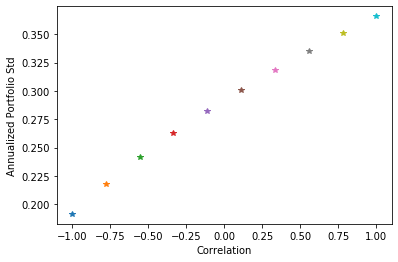

In [35]:
# Experimentation
p_vol = []; corr_values = np.linspace(-1,1,10)
print(corr_values)
for corr in corr_values:
    p_var = w['AAPL']**2*std['AAPL']**2+w['NKE']**2*std['NKE']**2+2*w['AAPL']*w['NKE']*corr*std['AAPL']*std['NKE']
    ann_p_sd = np.sqrt(p_var)*np.sqrt(252)
    p_vol.append(ann_p_sd)
    plt.plot(corr, ann_p_sd, '*')
plt.xlabel('Correlation'); plt.ylabel('Annualized Portfolio Std'); plt.show()

Thus, as we decrease the correlation between the assets we linearly decrease the risk (volatility or the standard deviation) of the portfolio.

#### 7. Building the mean-variance frontier

#### Testing the framework for a particular portfolio with two assets

In this first set of experiments, we'll devise a simple function that prints the return and volatility pairs of random portfolios in the mean-variance space.

We start by looking at how a given partfolio (with a particular set of weights) can reduce risk through diversification. Then, we evolve to consider multiple portfolios in the same space.

In [36]:
prices = quandl.get_table('SHARADAR/SEP', ticker=['AAPL', 'NKE'], date={'gte':'2000-01-01', 'lte':'2018-12-31'}, paginate=True)
pivoted = prices.pivot(index='date', columns='ticker', values='close')
pivoted.head()

ticker,AAPL,NKE
date,,
2018-09-04,228.36,79.60
2018-09-05,226.87,79.92
2018-09-06,223.10,80.40
2018-09-07,221.30,80.30
2018-09-10,218.33,82.10


In [37]:
cov_matrix = pivoted.pct_change().cov()
e_r = pivoted.pct_change().mean()
e_std = pivoted.pct_change().std()
print(cov_matrix)
print('\nEr:' , e_r)
print('\nEstd:', e_std)

ticker      AAPL       NKE
ticker                    
AAPL    0.000548  0.000266
NKE     0.000266  0.000484

Er: ticker
AAPL   -0.004285
NKE    -0.000639
dtype: float64

Estd: ticker
AAPL    0.023406
NKE     0.021996
dtype: float64


In [38]:
assets = pd.concat([e_r, e_std], axis=1)
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
ticker,,
AAPL,-0.004285,0.023406
NKE,-0.000639,0.021996


In [39]:
p_ret = []; p_vol = []; p_weights = []; num_assets = []
num_portfolios = 1 # for now
for portfolio in range(num_portfolios):
    
    weights = np.array([.25, .75]).reshape(1,-1)
    p_weights.append(weights)
    returns = np.dot(weights, e_r) # weighted avg. return  
    p_ret.append(returns[0])
    
    var = (weights.dot(np.array(cov_matrix))).dot(weights.T)[0][0]
    std = np.sqrt(var) 
    p_vol.append(std)

# creating a new df that hols all the portfolios
data = {'Returns':p_ret, 'Volatility':p_vol}
portfolios  = pd.DataFrame(data)
portfolios.index = ['portfolio_1']
portfolios

,Returns,Volatility
portfolio_1,-0.00155,0.020156


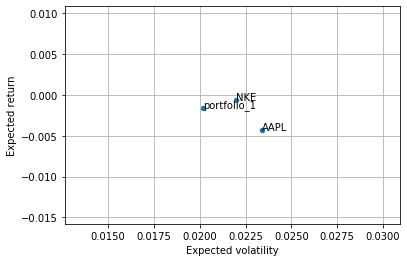

In [40]:
op_space = pd.concat([portfolios, assets])
ax = op_space.plot.scatter(x='Volatility', y='Returns', grid=True)
plt.xlabel('Expected volatility'); plt.ylabel('Expected return')
for i, txt in enumerate(op_space.index):
    ax.annotate(txt, (op_space['Volatility'][i], op_space['Returns'][i]))

As we can see above, the portfolio with given weights indeed decreased risk. Some people may prefer this portfolio instead of investing entirely in the individual assets. Let's find out if we can increase the return even further with a better combination of weights.

#### Plotting random portfolios

Now, we'll look at several random portfolios in a slightly more complex problem, with three possible investiments. No short-selling is allowed (only positive weights are generated).

In [41]:
# inlcuding a new ticker
prices = quandl.get_table('SHARADAR/SEP', ticker=['AAPL', 'KO', 'NKE'], date={'gte':'2000-01-01', 'lte':'2018-12-31'}, paginate=True)
pivoted = prices.pivot(index='date', columns='ticker', values='close')
pivoted.head()

ticker,AAPL,KO,NKE
date,,,
2018-09-04,228.36,44.76,79.60
2018-09-05,226.87,45.38,79.92
2018-09-06,223.10,45.77,80.40
2018-09-07,221.30,45.72,80.30
2018-09-10,218.33,46.06,82.10


In [42]:
# computing the basic metrics
cov_matrix = pivoted.pct_change().cov()
e_r = pivoted.pct_change().mean()
e_std = pivoted.pct_change().std()
assets = pd.concat([e_r, e_std], axis=1)
assets.columns = ['Returns', 'Volatility']

In [43]:
def random_mv_space(df, cov_matrix, num_portfolios):
    '''
    Plots the mean-variance space with random generated porfolios with positive weights.
    
    Parameters:
        df (pandas.DataFrame): holds the expected return and std of assets.
        cov_matrix (pandas.DataFrame): the convariance matrix of assets in 'df'.
        num_portfolios (int): number of portfolios to be randomly generated.
    Returns:
        portfolios (pandas.DataFrame): holds the expected return, expected volatility and weights of all random portfolios.
        mvp (pandas.Series): holds the expected return, expected volatility and weights of the minimum-variance portfolio.
    '''
    
    p_ret = []; p_vol = []; p_weights = []
    num_assets = df.shape[0]
    for portfolio in range(num_portfolios):
        
        weights = np.random.random(num_assets).reshape(1,-1) # short selling not allowed
        weights = weights/np.sum(weights) # normalizing the weights
        p_weights.append(weights)
        
        returns = np.dot(weights, np.array(assets['Returns'])) # weighted avg. return
        p_ret.append(returns[0])
        
        var = (weights.dot(np.array(cov_matrix))).dot(weights.T)[0][0]
        std = np.sqrt(var)
        p_vol.append(std)

    # building a data frame
    data = {'Returns':p_ret, 'Volatility':p_vol}
    for counter, symbol in enumerate(list(assets.index)):
        data[symbol+' weights'] = [w[0][counter] for w in p_weights]
    portfolios = pd.DataFrame(data)
    #print(portfolios.head())
    
    # plotting the data
    plt.figure(figsize=(20,10))
    plt.plot(data['Volatility'], data['Returns'], 'o', alpha=0.2, label='Random generated portfolios')
    
    # plotting portfolios with individual assets
    for i, txt in enumerate(assets.index):
        plt.plot(assets.loc[txt]['Volatility'], assets.loc[txt]['Returns'], 'o', alpha=0.6, label=txt)
    
    # plotting the portfolios with weights on 'KO' near zero
    df_no_ko = portfolios[portfolios['KO weights'] < 0.05]
    plt.plot(df_no_ko['Volatility'], df_no_ko['Returns'], 'o', alpha=0.4, label='KO weights < 0.05')
    df_no_ko = portfolios[portfolios['KO weights'] < 0.01]
    plt.plot(df_no_ko['Volatility'], df_no_ko['Returns'], 'o', alpha=0.4, label='KO weights < 0.01')
    
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.grid(); plt.legend()
    
    mvp = portfolios[portfolios['Volatility']==portfolios['Volatility'].min()]
    #print('Minimum variance portfolio:\n', mvp)
    
    return portfolios, mvp.squeeze()

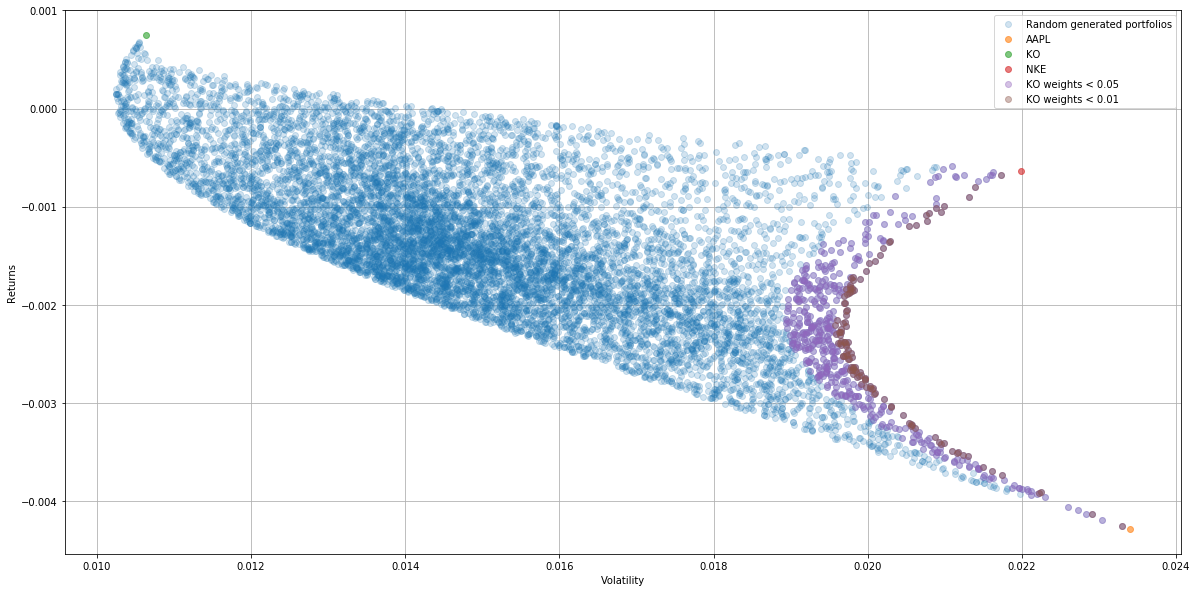

In [44]:
portfolios, mvp = random_mv_space(assets, cov_matrix, num_portfolios=10000)

As we can see above, there's a high gain from including the Coca-cola company in the portfolio. Further, a portfolio with only NKE and APPL stocks considerably reduces the risk.

Below, instead of generating random portfolios, we'll generated equally spaced portfolios with respect to their weights. Short-selling is allowed. The resolution of the generated points is controlled by a parameter.

It's not an scalable function, as its time complexity increases exponentially with the number of assets for the same resolution.

In [45]:
def spaced_mv_space(df, cov_matrix, resolution, short_selling):
    '''
    Plots the mean-variance space with equally spaced porfolios, including the mean-variance frontier,
    the efficient frontier, the minimum variance portfolio.
    
    Parameters:
        df (pandas.DataFrame): holds the expected return and std of assets.
        cov_matrix (pandas.DataFrame): the convariance matrix of assets in 'df'.
        resolution (float): the space between two weights.
    short_selling (Boolean): if 'True' allows for negative weights (which increases the time complexity). 
    
    Returns:
        portfolios (pandas.DataFrame): holds the expected return, expected volatility and weights of all random portfolios.
        mvp (pandas.Series): holds the expected return, expected volatility and weights of the minimum-variance portfolio.
    '''
    
    p_ret = []; p_vol = [];
    num_assets = df.shape[0]
    
    if short_selling:
        u_dist = np.arange(-1, 1+resolution, resolution)
        combs = [list(u_dist) for i in range(num_assets-1)]
        p_weights = list(itertools.product(*combs))
        # adding the last asset
        p_weights = [[w[0], w[1], np.round(1-w[0]-w[1], 4)] for w in p_weights]
    else:
        u_dist = np.arange(0, 1+resolution, resolution)
        combs = [list(u_dist) for i in range(num_assets-1)]
        p_weights = list(itertools.product(*combs))
        # adding the last asset
        p_weights = [[w[0], w[1], 1-w[0]-w[1]] for w in p_weights if (w[0]+w[1])<=1] # removes negative weights
    
    for weights in list(p_weights):
        
        weights = np.array(weights).reshape(1, -1)
        returns = np.dot(weights, np.array(assets['Returns'])) # weighted avg. return
        p_ret.append(returns[0])
        var = (weights.dot(np.array(cov_matrix))).dot(weights.T)[0][0]
        std = np.sqrt(var)
        p_vol.append(std)

    # building a data frame
    data = {'Returns':p_ret, 'Volatility':p_vol}
    for counter, symbol in enumerate(list(assets.index)): # add a key for each asset weight
        data[symbol+' weights'] = [w[counter] for w in np.array(p_weights)]
    portfolios = pd.DataFrame(data)
    #print(portfolios)
    
    # plotting all the points into the mean variance space
    plt.figure(figsize=(20,10))
    plt.plot(portfolios['Volatility'], portfolios['Returns'], 'o', alpha=0.2, label='Entire set of portfolios')
    
    # plotting the mean-variance frontier
    df_filtered = portfolios[['Returns', 'Volatility']]
    df_filtered.loc[:,'Returns'] = np.round(df_filtered['Returns'], 4)
    # we want to maintain same level of returns with the lowest volatility
    df_filtered = df_filtered.sort_values(by=['Returns', 'Volatility'], ascending=[True, True])
    df_filtered = df_filtered.drop_duplicates(subset='Returns', keep="first")
    plt.plot(df_filtered['Volatility'], df_filtered['Returns'], linewidth=2, alpha=0.6, label='Mean-variance frontier')
    
    # calculating the mvp and plotting the efficient frontier
    mvp = df_filtered[df_filtered['Volatility']==df_filtered['Volatility'].min()]
    df_eff = df_filtered[df_filtered['Returns']>=mvp['Returns'].values[0]]
    plt.plot(df_eff['Volatility'], df_eff['Returns'], linewidth=3, alpha=0.6, label='Efficient frontier')
    
    # plotting portfolios with individual assets
    for i, txt in enumerate(assets.index):
        plt.plot(assets.loc[txt]['Volatility'], assets.loc[txt]['Returns'], 'o', alpha=0.8, label=txt)
    
    # plotting the minimum variance portfolio
    plt.plot(mvp['Volatility'], mvp['Returns'], 'x', markersize=12, label='Minimum-variance port.')
    
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.grid()
    plt.legend()
    
    return portfolios, mvp

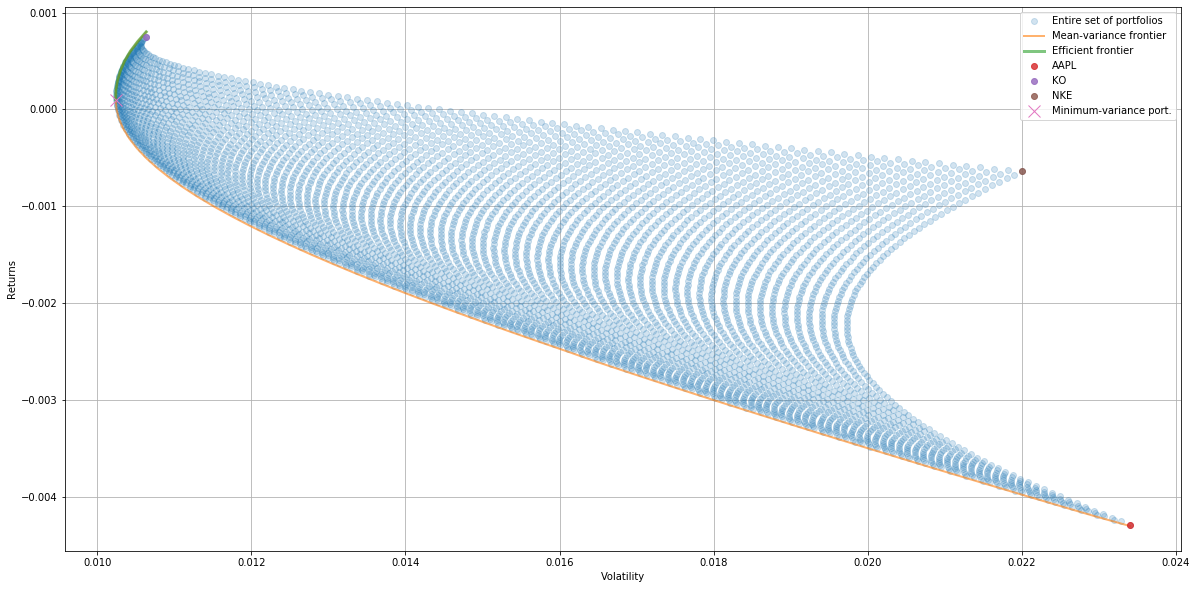

In [48]:
portfolios, mvp = spaced_mv_space(assets, cov_matrix, resolution=0.01, short_selling=False)

Any portfolio will be considered as a member of the **mean-variance frontier**, if and only if **there's no other portfolio with lower variance for the same level of return.**

*Note: Actually, above we don't have the entire MV frontier, as weights were restricted to be positive.*

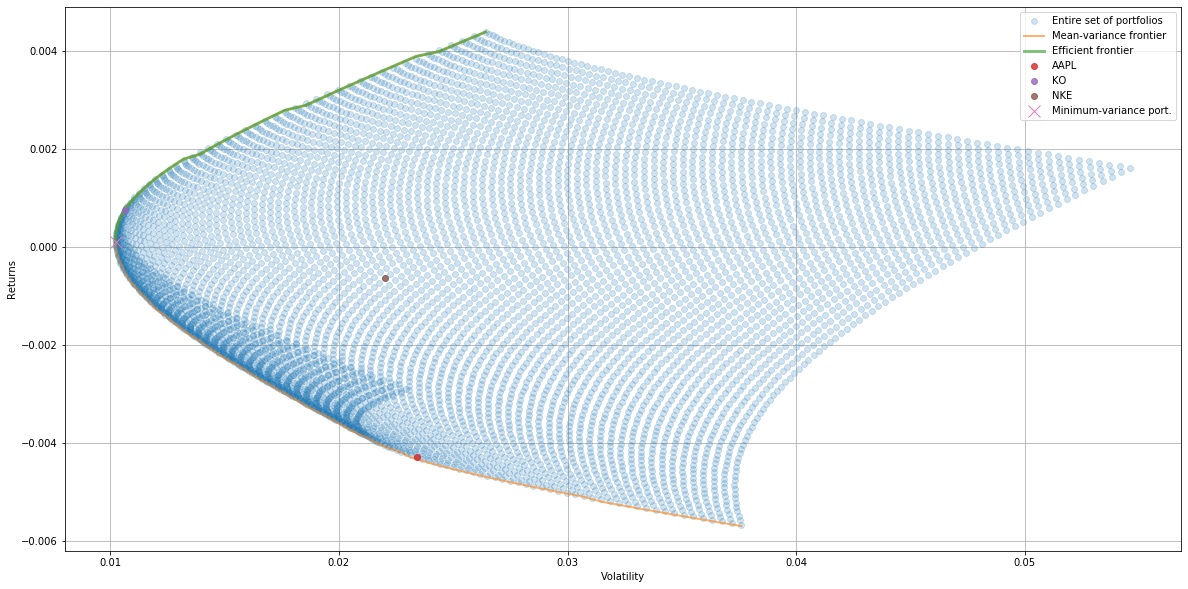

In [47]:
portfolios, mvp = spaced_mv_space(assets, cov_matrix, resolution=0.025, short_selling=True)

By including short-selling the mean-variance frontier is completed and a whole new set of efficient portfolios is available.